In [0]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


In [0]:
MAX_BATCH_EPISODES = 100
MAX_BATCH_STEPS = 1000
NOISE_STD = 0.01
LR = 1e-3
UPDATE_L2 = []

In [0]:
class Brain(nn.Module):
  def __init__(self, state_size, action_size, hidden_size = 32):
    super(Brain, self).__init__()
    self.brain = nn.Sequential(
                  nn.Linear(state_size, hidden_size),
                  nn.ReLU(),
                  nn.Linear(hidden_size, action_size),
                  nn.Softmax(dim = 1))
    
  def forward(self, x):
    return self.brain(x)
  
def evaluate(env, brain):
  """
  Runs an evaluation on the given brain.
  """
  state = env.reset()
  rewards = 0
  steps = 0
  while True:
    state = torch.from_numpy(state).unsqueeze(0).float()
    action_prob = brain(state)

    action = action_prob.max(dim = 1)[1]

    next_state, reward, done, _ = env.step(action.data.numpy()[0])
    rewards += reward
    steps  += 1
    state = next_state
    if done:
      break
      
  return rewards, steps


def sample_noise(brain):
  """
  
  """
  pos = []
  neg = []
  for param in brain.parameters():
    noise_t = torch.tensor(np.random.normal(size = param.data.size()).astype(np.float32))
    pos.append(noise_t)
    neg.append(-noise_t)
  return pos, neg


def eval_with_noise(env, brain, noise):
  """
  Evaluates the current brain with added parameter noise
  
  """
  
  old_params = brain.state_dict()
  for p, p_n in zip(brain.parameters(), noise):
    p.data += NOISE_STD*p_n
  r, s = evaluate(env, brain)
  brain.load_state_dict(old_params)
  return r, s 


def train_step(brain, batch_noise, batch_rewards, step_idx):
  """
  
  """
  # normalize rewards to have zero mean and unit variance
  norm_reward = np.array(batch_reward)
  norm_reward -= np.mean(norm_reward)
  s = np.std(norm_reward)
  if abs(s) > 1e-6:
    norm_reward /= s
  weighted_noise = None
  for noise, reward in zip(batch_noise, norm_reward):
    if weighted_noise is None:
      weighted_noise = [reward * p_n for p_n in noise]
    else:
      for w_n, p_n in zip(weighted_noise, noise):
        w_n += reward * p_n
        
  m_updates = []
  for p, p_update in zip(brain.parameters(), weighted_noise):
    update = p_update / (len(batch_reward)*NOISE_STD)
    p.data += LR * update
    m_updates.append(torch.norm(update))
  UPDATE_L2.append(np.mean(m_updates))
  

Brain(
  (brain): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
    (3): Softmax()
  )
)
Step: 230, Reward: 177.83
Solved the environment in 231 steps


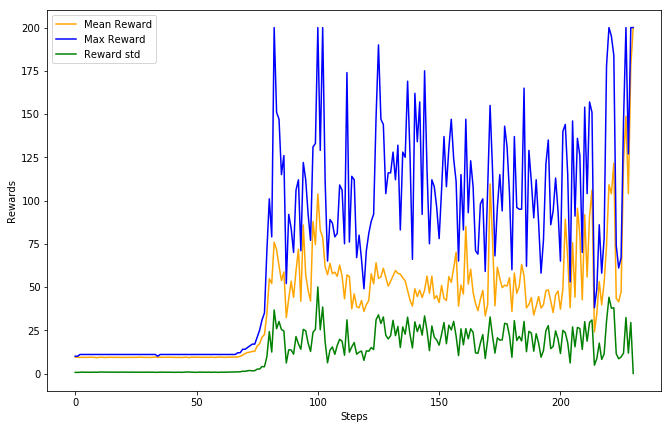

In [0]:
env = gym.make("CartPole-v0")
brain = Brain(env.observation_space.shape[0], env.action_space.n, hidden_size = 16)
print(brain)
step_idx = 0
reward_history = []
reward_max =[]
reward_std = []

while True:
  batch_noise = []
  batch_reward = []
  batch_steps = 0
  for _ in range(MAX_BATCH_EPISODES):
    noise, neg_noise = sample_noise(brain)
    batch_noise.append(noise)
    batch_noise.append(neg_noise)
    reward, steps = eval_with_noise(env, brain, noise)
    batch_reward.append(reward)
    batch_steps += steps
    reward, steps = eval_with_noise(env, brain, neg_noise)
    batch_reward.append(reward)
    batch_steps += steps
    if batch_steps > MAX_BATCH_STEPS:
      break
  
  step_idx += 1
  m_reward = np.mean(batch_reward)
  reward_history.append(m_reward)
  reward_max.append(np.max(batch_reward))
  reward_std.append(np.std(batch_reward))
  if m_reward > 199:
    print("\nSolved the environment in {} steps".format(step_idx))
    break
  train_step(brain, batch_noise, batch_reward, step_idx)
  
  print("\rStep: {}, Reward: {:.2f}".format(step_idx, m_reward), end = "", flush = True)
  

  
plt.figure(figsize = (11,7))
plt.plot(reward_history, label = "Mean Reward", color = "orange")
plt.plot(reward_max, label = "Max Reward", color = "blue")
plt.plot(reward_std, label = "Reward std", color = "green")
plt.xlabel("Steps")
plt.ylabel("Rewards")
plt.legend()
plt.show()